In [9]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pandas as pd
from tqdm import tqdm # this is just a tool to show a progress bar as your simulations are running

# Assignment 10: Nested Spheres

Simulation is an incredibly useful tool in data science.  We can use simulation to evaluate how algorithms perform against ground truth, and how algorithms compare to one another.

In this assignment, you will be implementing and extending the nested spheres simulation study found in *Elements of Statistical Learning* page 339. https://web.stanford.edu/~hastie/ElemStatLearn/

# Nested Spheres

Consider a dataset which contains 10 features $X_1 \,, X_2 \,, \cdots \,, X_{10}$.  The features are standard independent Gaussian random variables.  That is to say

$$ X_j \sim \operatorname{Normal}(0,1) \quad \forall j = 1 \dots 10$$

We are going to use these features to study a classification problem.  You will have to create the target variable, $Y$ by computing the following rule:

$$ Y = \begin{cases}  1 \quad \mbox{ if } \sum_{j=1}^{10} X^2_j>9.34 \\ 0 \quad  \mbox{else} \end{cases}$$

# The Simulation Study

Follow these steps to complete the assignment. 

### Part 1 ( X / 25 pts )
Write a function, `generate_data`, that takes a dataset size N and creates a dataset according to the rule above, returning the feature matrix `X` and the labels `y`.

In [10]:
def generate_data(N):
    # Create feature matrix X and labels y
    X = np.random.normal(0, 1, size = (N, 10))
    y = np.zeros((N, 1))
    for i in range(N):
        y[i] = 1 if np.sum(X[i, :]*X[i, :])>9.34 else 0
    return X, y

## Part 2 ( X / 25 pts )

Write a function `run_simulation` that accepts two numbers, Ntrain and Ntest. It should generate a training set and testing set using your `generate_data` function and then train **four classifiers**. The first should be a bagged decision tree, the second should be a random forest with `max_features=1`, the third should be a random forest with `max_features=3`, and the fourth can be anything you like, for example a random forest with more features or an XGboost model. Use 500 trees in your random forests and the bagged classifier. The function should return the accuracy for each of these models estimated using the training set you generated.

In [11]:
def run_simulation(NtrainX, Ntrainy, NtestX, Ntesty):
    
    # Code to generate data and run one simulation
    bag = BaggingClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=500, n_jobs = 28)
    rf_mf1 = RandomForestClassifier(n_estimators=500, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=1, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=28, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=0, # Seed
                       verbose=0, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced')
    rf_mf3 = RandomForestClassifier(n_estimators=500, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=3, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=28, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=0, # Seed
                       verbose=0, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced')
    my_classifier = XGBClassifier(max_depth=1,                 # Depth of each tree
                            learning_rate=0.05,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=500,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=28,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=0,        # Seed
                            missing=None)
   
    models = [bag, rf_mf1, rf_mf3, my_classifier]
    predictions = np.zeros((NtestX.shape[0], len(models)))
    
    for i, model in enumerate(models):
        model.fit(NtrainX, Ntrainy)
        predictions[:, i] = model.predict(NtestX)
        
    bag_accuracy = accuracy_score(Ntesty, predictions[:,0])
    rf_mf1_accuracy = accuracy_score(Ntesty, predictions[:,1])
    rf_mf3_accuracy = accuracy_score(Ntesty, predictions[:,2])
    my_classifier_accuracy = accuracy_score(Ntesty, predictions[:,3])
    
    return bag_accuracy, rf_mf1_accuracy, rf_mf3_accuracy, my_classifier_accuracy

## Part 3 ( X / 25 pts )

Run 50 simulations using a training set of size 1000 and a test set of size 5000 and record all the results in four vectors, one for each type of model. *You should probably debug your code using smaller training and test set sized first because these will take a while. The full simulation takes 10 minutes on my old 2.8GHz core i5 laptop.*

In [12]:
#Setup code to record results here:
Nsim=50
accuracy50 = np.zeros((Nsim, 4))

#Loop to run simulations:
for sim in tqdm(range(Nsim)):
    # Run simulations, collect data
    trainX, trainy = generate_data(1000)
    testX, testy = generate_data(5000)
    accuracy50[sim, :] = run_simulation(trainX, trainy, testX, testy)
    
print(accuracy50)

  0%|          | 0/50 [00:00<?, ?it/s]/home/lingxia/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-11-ce4423037d28>:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(NtrainX, Ntrainy)
<ipython-input-11-ce4423037d28>:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(NtrainX, Ntrainy)
/home/lingxia/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
  2%

[[0.767  0.873  0.8624 0.8594]
 [0.7104 0.8518 0.842  0.8476]
 [0.7212 0.8692 0.8612 0.8382]
 [0.7254 0.8634 0.8488 0.8426]
 [0.6816 0.8528 0.83   0.8348]
 [0.7694 0.871  0.8514 0.8484]
 [0.735  0.8594 0.8532 0.8482]
 [0.7332 0.8636 0.8428 0.849 ]
 [0.7424 0.86   0.8496 0.8356]
 [0.7138 0.853  0.8416 0.837 ]
 [0.7406 0.8474 0.8312 0.8366]
 [0.6912 0.8686 0.8454 0.8384]
 [0.7128 0.8538 0.8304 0.8392]
 [0.729  0.871  0.8562 0.85  ]
 [0.7168 0.8678 0.847  0.8468]
 [0.7192 0.8518 0.8444 0.8348]
 [0.6926 0.8506 0.838  0.838 ]
 [0.7522 0.8674 0.8508 0.8526]
 [0.7192 0.858  0.8396 0.844 ]
 [0.7258 0.8748 0.8454 0.8362]
 [0.727  0.8646 0.839  0.8476]
 [0.7488 0.8492 0.8324 0.8458]
 [0.712  0.8516 0.8364 0.8286]
 [0.7544 0.864  0.8546 0.856 ]
 [0.7128 0.8578 0.8362 0.8322]
 [0.6992 0.858  0.8544 0.8504]
 [0.7398 0.8716 0.8538 0.8576]
 [0.7374 0.8532 0.8362 0.8406]
 [0.7476 0.8664 0.855  0.8524]
 [0.7204 0.8576 0.8456 0.8442]
 [0.7408 0.8598 0.8534 0.8458]
 [0.7162 0.8664 0.8432 0.8446]
 [0.6772

## Part 4 (X / 25 pts) 
Plot the error rates for each model using a boxplot for each one. The four models should be across the x-axis, and the y-axis should be accuracy.

{'whiskers': [<matplotlib.lines.Line2D at 0x151d0490dfa0>,
 'caps': [<matplotlib.lines.Line2D at 0x151d0490dd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x151d4e62b190>,
 'medians': [<matplotlib.lines.Line2D at 0x151d04a9f310>,
 'fliers': [<matplotlib.lines.Line2D at 0x151d04a9f5e0>,
 'means': []}

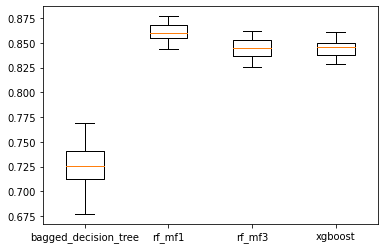

In [13]:
#Plot the error rates as a box plot by model to complete the assignment.
plt.boxplot(accuracy50, labels=['bagged_decision_tree', 'rf_mf1', 'rf_mf3', 'xgboost'])